<a href="https://colab.research.google.com/github/AliAkbarBadri/topics-for-types/blob/main/types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
! pip -q install laserembeddings
! python -m laserembeddings download-models
! pip -q install transformers

     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 860kB 15.7MB/s 

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!
     |████████████████████████████████| 1.3MB 4.5MB/s 
     |████████████████████████████████| 2.9MB 23.9MB/s 
     |████████████████████████████████| 1.1MB 32.3MB/s 


In [2]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoTokenizer, AutoModel
from laserembeddings import Laser
from __future__ import unicode_literals

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LASER

In [4]:
laser = Laser()

In [5]:
df_types_laser = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_laser.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0


In [6]:
df_types_laser['sentence'] = df_types_laser['sentence'].apply(lambda sent: laser.embed_sentences(sent, lang='fa')[0])
df_types_laser.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[0.020942228, -8.114154e-05, -0.0009854112, 0....",0,0,0,0,1,1,0,0,0,1,0,0
1,"[0.00867996, 0.0027223467, -0.00016234924, 0.0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.011158594, 0.018385716, -8.350732e-05, 0.01...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.009575151, 0.01364643, 7.700209e-05, 0.0117...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[0.027029106, 0.002408459, 0.00048337242, 0.00...",0,0,0,0,1,0,0,0,1,1,0,0


In [7]:
X = np.array(df_types_laser[df_types_laser.columns[0]])
X = np.vstack(X)

Y = df_types_laser[df_types_laser.columns[1:]].values

X.shape, Y.shape

((2424, 1024), (2424, 12))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [9]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

**metrics**
  - F-measure
  - HammingLoss
  - Accuracy
  - Macro F-Measure
  - Micro F-Measure



In [21]:
import tensorflow_addons as tfa

In [122]:
def tf_f1_score(y_true, y_hat, thresh=0.5):
    """Computes 3 different f1 scores, micro macro
    weighted.
    micro: f1 score accross the classes, as 1
    macro: mean of f1 scores per class
    weighted: weighted average of f1 scores per class,
            weighted from the support of each class


    Args:
        y_true (Tensor): labels, with shape (batch, num_classes)
        y_pred (Tensor): model's predictions, same shape as y_true

    Returns:
        tuple(Tensor): (micro, macro, weighted)
                    tuple of the computed f1 scores
    """

    f1s = [0, 0, 0]

    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float64)

    for i, axis in enumerate([None, 0]):
        TP = tf.math.count_nonzero(y_pred * y_true, axis=axis)
        FP = tf.math.count_nonzero(y_pred * (y_true - 1), axis=axis)
        FN = tf.math.count_nonzero((y_pred - 1) * y_true, axis=axis)

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)

        f1s[i] = tf.reduce_mean(f1)

    weights = tf.reduce_sum(y_true, axis=0)
    weights /= tf.reduce_sum(weights)

    f1s[2] = tf.reduce_sum(f1 * weights)
    return f1s

    # micro, macro, weighted = f1s
    # return micro.numpy(), macro.numpy(), weighted.numpy()

In [124]:
actuals = tf.constant([[1, 0, 1, 0],
                       [0, 1, 0, 1],
                       [0, 0, 0,1]], 
                      dtype=tf.int32)
predictions = tf.constant([[0.82, 0.5, 0.90, 0],
                           [0, 1, 0.4, 0.98],
                           [0.89, 0.79, 0, 0.3]],
                           dtype=tf.float32)
f1s = tf_f1_score(actuals, predictions)
print("Micro: ",f1s[0].numpy())
print("Macro: ",f1s[1].numpy())
print("Weighted: ",f1s[2].numpy())

Micro:  0.7272727272727272
Macro:  0.75
Weighted:  0.7333333333333334


In [87]:
def f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    return f1

def micro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=1), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=1), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=1), tf.float32)
    f1_measure = 2*tp / (2*tp + fn + fp + 1e-16)
    return tf.reduce_mean(f1_measure)

def macro_f1(y, y_hat, thresh=0.5):
    f1_measure = f1(y, y_hat)
    macro_f1 = tf.reduce_mean(f1_measure)
    return macro_f1

In [125]:
hamloss = tfa.metrics.HammingLoss(mode='multilabel', threshold=0.5)
macro = tfa.metrics.f_scores.F1Score(4,'macro',threshold=0.5, name='macro')
micro = tfa.metrics.f_scores.F1Score(4,'micro',threshold=0.5, name='micro')
f1 = tfa.metrics.f_scores.F1Score(4,None,threshold=0.5, name='f1')
weighted = tfa.metrics.f_scores.F1Score(4,'weighted',threshold=0.5, name='f1')

actuals = tf.constant([[1, 0, 1, 0],
                       [0, 1, 0, 1],
                       [0, 0, 0,1]], 
                      dtype=tf.int32)
predictions = tf.constant([[0.82, 0.5, 0.90, 0],
                           [0, 1, 0.4, 0.98],
                           [0.89, 0.79, 0, 0.3]],
                           dtype=tf.float32)

f1.update_state(actuals, predictions)
macro.update_state(actuals, predictions)
micro.update_state(actuals, predictions)
weighted.update_state(actuals, predictions)
hamloss.update_state(actuals, predictions)



print('Hamming loss: ', hamloss.result().numpy()) # 0.16666667
print('-------')

print('F1: ', f1.result().numpy())
print('Micro: ', micro.result().numpy())
print('Macro: ', macro.result().numpy())
print('Weighted: ', weighted.result().numpy())

# print(tf.reduce_mean(f1.result().numpy()))
# print("------")
# print("F1: ", f1(actuals, predictions).numpy())
# print("Macro: ",macro_f1(actuals, predictions).numpy())
# print("Micro: ",micro_f1(actuals, predictions).numpy())


Hamming loss:  0.25
-------
F1:  [0.6666667 0.6666667 1.        0.6666667]
Micro:  0.72727275
Macro:  0.75
Weighted:  0.73333335


In [126]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer'),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Output'),
  ], name='LASER_Model')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(12,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(12,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(12,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "LASER_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 100)               102500    
_________________________________________________________________
Output (Dense)               (None, 12)                1212      
Total params: 103,712
Trainable params: 103,712
Non-trainable params: 0
_________________________________________________________________
None


In [127]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
218/218 [==============================] - 1s 5ms/step - loss: 0.3458 - acc: 0.4834 - f1: 0.3750 - macro: 0.0991 - micro: 0.5216 - hamloss: 0.1214 - val_loss: 0.2786 - val_acc: 0.4943 - val_f1: 0.4261 - val_macro: 0.1172 - val_micro: 0.5710 - val_hamloss: 0.1117
Epoch 2/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2647 - acc: 0.4627 - f1: 0.4807 - macro: 0.1390 - micro: 0.5966 - hamloss: 0.1082 - val_loss: 0.2543 - val_acc: 0.4577 - val_f1: 0.5250 - val_macro: 0.1611 - val_micro: 0.6256 - val_hamloss: 0.1032
Epoch 3/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2431 - acc: 0.4805 - f1: 0.5741 - macro: 0.1863 - micro: 0.6604 - hamloss: 0.0964 - val_loss: 0.2382 - val_acc: 0.4943 - val_f1: 0.5988 - val_macro: 0.2060 - val_micro: 0.6820 - val_hamloss: 0.0923
Epoch 4/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2252 - acc: 0.5883 - f1: 0.6242 - macro: 0.2138 - micro: 0.7039 - hamloss: 0.0867 - val_loss: 0.2252 -

In [128]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.1957 - acc: 0.6049 - f1: 0.7468 - macro: 0.3873 - micro: 0.7639 - hamloss: 0.0754


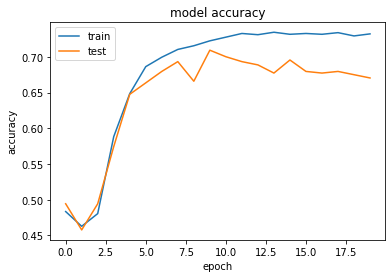

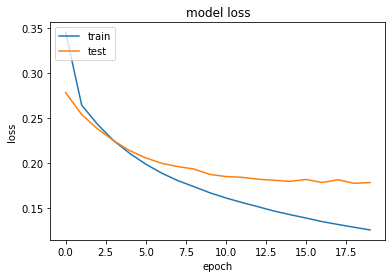

In [129]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# BERT

In [130]:
config = AutoConfig.from_pretrained("m3hrdadfi/albert-fa-base-v2")
tokenizer = AutoTokenizer.from_pretrained("m3hrdadfi/albert-fa-base-v2")
bert_model = AutoModel.from_pretrained("m3hrdadfi/albert-fa-base-v2")

In [ ]:
# def get_embedding(sent):
#     input_sentence = torch.tensor(tokenizer.encode(sent, max_length = 500)).unsqueeze(0)
#     out = bert_model(input_sentence)
#     embeddings_of_last_layer = out[0]
#     cls_embeddings = embeddings_of_last_layer[0][0]
#     cls_embeddings = cls_embeddings.detach().numpy()
#     return cls_embeddings

In [ ]:
# df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")

In [ ]:
# df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda sent: get_embedding(sent))
# df_types_bert.to_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv", index=False)
# df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.5841074, -0.017078003, -0.32405344, -0.645...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.31120673, -0.0050979797, 0.10509731, -0.36...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.05544515, -0.23301096, 0.12021764, -0.33959...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.37881416, -0.1909234, 0.16427912, -0.383240...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.46968994, -0.2401005, 0.20189604, -0.20498...",0,0,0,0,1,0,0,0,1,1,0,0


In [131]:
df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv")
df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))
df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0


In [132]:
X = np.array(df_types_bert[df_types_bert.columns[0]])
X = np.vstack(X)

Y = df_types_bert[df_types_bert.columns[1:]].values

X.shape, Y.shape

((2424, 768), (2424, 12))

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [134]:
len(X_train),len(X_test),len(y_train),len(y_test)

(1939, 485, 1939, 485)

In [135]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer',
                          activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout"),
    # tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2',
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer3'),

  ], name='BERT_MODEL')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(12,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(12,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(12,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "BERT_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 100)               76900     
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                1212      
Total params: 78,112
Trainable params: 78,112
Non-trainable params: 0
_________________________________________________________________
None


In [136]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
194/194 [==============================] - 1s 7ms/step - loss: 0.4624 - acc: 0.5255 - f1: 0.5369 - macro: 0.1805 - micro: 0.6046 - hamloss: 0.1144 - val_loss: 0.3691 - val_acc: 0.5979 - val_f1: 0.5414 - val_macro: 0.1615 - val_micro: 0.6403 - val_hamloss: 0.0956
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3395 - acc: 0.6518 - f1: 0.5835 - macro: 0.1887 - micro: 0.6777 - hamloss: 0.0914 - val_loss: 0.3221 - val_acc: 0.6701 - val_f1: 0.5743 - val_macro: 0.1729 - val_micro: 0.6661 - val_hamloss: 0.0883
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3024 - acc: 0.7008 - f1: 0.6030 - macro: 0.1961 - micro: 0.6968 - hamloss: 0.0861 - val_loss: 0.2941 - val_acc: 0.7062 - val_f1: 0.5908 - val_macro: 0.1807 - val_micro: 0.6774 - val_hamloss: 0.0861
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.2801 - acc: 0.7079 - f1: 0.6138 - macro: 0.2026 - micro: 0.7049 - hamloss: 0.0838 - val_loss: 0.2794 -

In [137]:
score = model.evaluate(X_test, y_test, verbose=1)

16/16 [==============================] - 0s 4ms/step - loss: 0.2431 - acc: 0.7175 - f1: 0.6816 - macro: 0.3071 - micro: 0.7249 - hamloss: 0.0806


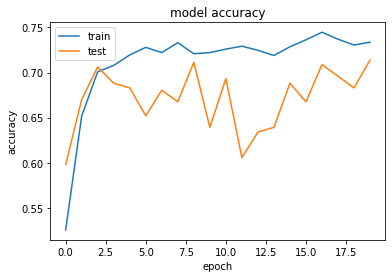

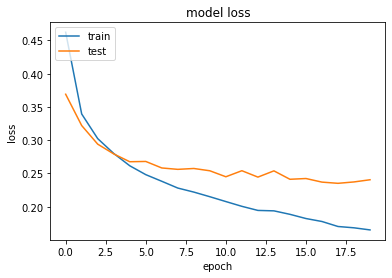

In [138]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Word2Vec

In [ ]:
df_types_lstm = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_lstm.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
X = df_types_lstm[df_types_lstm.columns[0]].values
Y = df_types_lstm[df_types_lstm.columns[1:]].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
vocab_size, X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8587, (2181, 200), (2181, 12), (243, 200), (243, 12))

In [ ]:
embeddings_dictionary = dict()

glove_file = open('drive/My Drive/nlp/similarity/embeddings/twitt_wiki_ham_blog.fa.text.100.vec', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim = 100, 
                            weights=[embedding_matrix],
                            trainable=False, name='Embedding_Layer'),
    tf.keras.layers.LSTM(200,
                        # return_sequences=True,
                        # stateful=True,
                        recurrent_initializer='glorot_uniform',
                        name='LSTM_Layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer1'),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer2')
  ], name='LSTM_Model')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['acc'])
print(model.summary())
print()
print(model.layers[0].weights)

Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 200, 100)          858700    
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 200)               240800    
_________________________________________________________________
Dense_Layer1 (Dense)         (None, 100)               20100     
_________________________________________________________________
Dense_Layer2 (Dense)         (None, 12)                1212      
Total params: 1,120,812
Trainable params: 262,112
Non-trainable params: 858,700
_________________________________________________________________
None

[<tf.Variable 'Embedding_Layer/embeddings:0' shape=(8587, 100) dtype=float32, numpy=
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-2.222517, -0.428454, -1.253941, ...,  0.361452,  1.8

In [ ]:
history = model.fit(X_train, y_train, batch_size=8, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
218/218 [==============================] - 3s 14ms/step - loss: 0.2905 - acc: 0.4862 - val_loss: 0.2934 - val_acc: 0.5263
Epoch 2/15
218/218 [==============================] - 3s 14ms/step - loss: 0.2893 - acc: 0.4857 - val_loss: 0.2911 - val_acc: 0.5263
Epoch 3/15
218/218 [==============================] - 3s 14ms/step - loss: 0.2890 - acc: 0.4857 - val_loss: 0.2918 - val_acc: 0.5263
Epoch 4/15
218/218 [==============================] - 3s 14ms/step - loss: 0.2885 - acc: 0.4857 - val_loss: 0.2915 - val_acc: 0.5263
Epoch 5/15
218/218 [==============================] - 3s 14ms/step - loss: 0.2886 - acc: 0.4857 - val_loss: 0.2920 - val_acc: 0.5263
Epoch 6/15
218/218 [==============================] - 3s 15ms/step - loss: 0.2881 - acc: 0.4857 - val_loss: 0.2900 - val_acc: 0.5263
Epoch 7/15
218/218 [==============================] - 3s 15ms/step - loss: 0.2884 - acc: 0.4857 - val_loss: 0.2900 - val_acc: 0.5263
Epoch 8/15
218/218 [==============================] - 3s 15ms/step - 

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

8/8 [==============================] - 0s 8ms/step - loss: 0.2996 - acc: 0.4321
Test Score: 0.29961177706718445
Test Accuracy: 0.43209877610206604
